In [ ]:
import os
import numpy as np
import pandas as pd
import torch 

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
import datetime

# Compute unix epoch to date table

def _prep_unix_epoch_to_date(max_year = 2025):
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    max_day = (datetime.datetime(max_year, 1, 1, 0, 0) - datetime.datetime(1970, 1, 1, 0, 0)).days 
    unix_epoch = [i for i in range(max_day)]
    date_times = [datetime.datetime(1970, 1, 1, 0, 0) + datetime.timedelta(i) for i in range(max_day)]

    def as_SowDate(date_time):
        day = f'{date_time.day}'
        if len(day) == 1:
            return(f'0{day}-{month_abbr[date_time.month - 1]}')
        else:
            return(f'{day}-{month_abbr[date_time.month - 1]}')

    tmp = pd.DataFrame({
        'Unix': unix_epoch,
        'Year':[e.year for e in date_times],
        'Month':[e.month for e in date_times],
        'Day':[e.day for e in date_times],
        'SowDate':[as_SowDate(date_time = e) for e in date_times]
    })
    _ = tmp.loc[:, ['Unix', 'Year']].groupby(['Year']).min().reset_index().rename(columns={'Unix':'MinUnix'})
    tmp = tmp.merge(_)

    tmp['DOY'] = tmp['Unix'] - tmp['MinUnix']
    tmp = tmp.drop(columns = ['MinUnix'])
    return tmp

In [ ]:
# how bad would it be if we stored a bunch of tiny parquet files? 
# saving many tiny parquet files will increase storage cost by 1.6x
# That's not great but not horrible either. We're talking about approximately 500 gb.
# (305213583096*1.6)/1000000000
# 488.34

# apsimx_sim_parquet_dir = '/home/Shared/cultivar_sim_exps'
# Result = pq.read_table(apsimx_sim_parquet_dir+'/'+'sim_1698440407_4739.parquet').to_pandas()

# -rw-rw-r-- 1 kickd newgroup 2939581425 Jun  1 01:08 cultivar_sim_exps/sim_1698440407_4739.parquet


# for i in tqdm(Result.FactorialUID.unique()):
#     table = Result.loc[(Result.FactorialUID == i), ].drop(columns = 'FactorialUID')
#     table = pa.Table.from_pandas(table)
#     pq.write_table(table, f'/home/Shared/testing_rm_after0620/{i}.parquet')

# 100%|██████████| 24025/24025 [33:58<00:00, 11.79it/s]

In [ ]:
# The goal is to have a (postgres?) SQL db that we can query. To not have a delay we're going to instead load a batch into memory BUT allow for redefining this batch by swapping out the dataloader.

# Workflow:
# Define the desired data 
# Use the main tables to figure out what parquet files we need to pull from.
# Pull all the data in and represent as tensors

In [ ]:
apsimx_sim_parquet_dir = '/home/Shared/cultivar_sim_exps'
os.listdir(apsimx_sim_parquet_dir)[0:3]

['sim_1698440407_4739.parquet',
 'sim_1697418008_10643.parquet',
 'sim_1697187607_79518.parquet']

In [ ]:
[e for e in os.listdir(apsimx_sim_parquet_dir) if e[0:4] != 'sim_']

['DefaultCultivarsAll.parquet', 'Genotypes.parquet', 'Ids.parquet']

In [ ]:
# metadata 
DefaultCultivarsAll = pq.read_table(apsimx_sim_parquet_dir+'/'+'DefaultCultivarsAll.parquet').to_pandas()
Genotypes           = pq.read_table(apsimx_sim_parquet_dir+'/'+'Genotypes.parquet').to_pandas()
Ids                 = pq.read_table(apsimx_sim_parquet_dir+'/'+'Ids.parquet').to_pandas()

In [ ]:
# I'm setting up a class to help find the files we need to read through to build the datset 
# This works by holding a copy of the Ids and Genotypes tables. 
# We'll operate on those, filtering them down until the tables only contain the enries we want to use.
# Next we'll use a that produces tuples of the (parquet file, filtering criteria)

class data_helper():
    def __init__(self, genotypes_path, ids_path, results_path):
        # used later to get the results. Append / if there isn't one.
        if results_path[-1] != '/': 
            results_path = results_path+'/'
        self.results_path = results_path

        Genotypes = pq.read_table(genotypes_path).to_pandas()
        # coerce None to NaN (default cultivars don't have all values specified)
        for e in [ee for ee in list(Genotypes) if ee not in ['File', 'Genotype']]:
            Genotypes[e] = Genotypes[e].astype(float)
        mask = (Genotypes.isna().sum(axis = 1) == 0)

        self.Genotypes = Genotypes.loc[mask, ].reset_index(drop = True)
        self.Ids = pq.read_table(ids_path).to_pandas()
    
    def apply_mask(self, table, mask):
        "This method takes care of automatically filtering the non-masked table."
        if table not in ['Genotypes', 'Ids']:
            print('table should be Genotypes or Ids')   
        else:
            if table == 'Genotypes':
                # apply mask to filter the table
                self.Genotypes = self.Genotypes.loc[mask, ].reset_index(drop = True)
                # left join to update the other table
                self.Ids = self.Genotypes.loc[:, ['File', 'Genotype']
                                        ].drop_duplicates(
                                        ).merge(self.Ids, how = 'left'
                                        ).reset_index(drop = True)
            elif table == 'Ids':
                self.Ids = self.Ids.loc[mask, ].reset_index(drop = True)
                self.Genotypes = self.Ids.loc[:, ['File', 'Genotype']
                                    ].drop_duplicates(
                                    ).merge(self.Genotypes, how = 'left'
                                    ).reset_index(drop = True)
    def get_results(self, years = [], dry_run = True):
        # Now we can ask for the files that we should get
        tmp = self.Ids.loc[:, ['File', 'Genotype', 'FactorialUID']]

        get_files = tmp.File.drop_duplicates().to_list()
        print(f'{len(get_files)} files to be read.')

        if dry_run == True:
            print('In dry_run, reading no files')

        if dry_run == False:
            res_list = []
            col_order = ''
            for file in tqdm(get_files):
                # print(f'{file}')
                res = pq.read_table(f'{x.results_path+file}.parquet').to_pandas()

                # columns should be in the same order, but we will force them to be here. 
                if col_order == '':
                    col_order = list(res)

                # filter order established with some informal testing.
                # runtime filter years, factorials: [10, 11.3, 10.5]
                # runtime filter factorials, years: [9.0, 8.4, 9.6]

                # filter factorials
                res = tmp.loc[(tmp.File == file), ['FactorialUID']].merge(res)

                # filter years
                if years != []:
                    yr = _prep_unix_epoch_to_date(max_year = 2030)
                    yr = yr.loc[(yr.Year.isin(years)), ['Unix']].rename(columns={'Unix':'Date'})
                    res = yr.merge(res)

                res_list.append(res)
            res_list = pd.concat(res_list).reset_index(drop=True)
            self.results = res_list


x = data_helper(
    genotypes_path = apsimx_sim_parquet_dir+'/'+'Genotypes.parquet',
    ids_path = apsimx_sim_parquet_dir+'/'+'Ids.parquet',
    results_path = apsimx_sim_parquet_dir)

# restrict to simulated cultivars with the maximum MaximumGrainsPerCob
mask = (x.Genotypes['Grain.MaximumGrainsPerCob.FixedValue'] == x.Genotypes['Grain.MaximumGrainsPerCob.FixedValue'].max())

print(f'Before Mask: Genotypes: {x.Genotypes.shape} Ids: {x.Ids.shape}')
x.apply_mask(table='Genotypes', mask=mask)
print(f'After Mask: Genotypes: {x.Genotypes.shape} Ids: {x.Ids.shape}')

Before Mask: Genotypes: (3150, 17) Ids: (2837275, 7)
After Mask: Genotypes: (5, 17) Ids: (4247, 7)


In [ ]:
# Now let's select a region of the country. For this demonstration I'll filter to a region around Columbia MO.

mask = ((x.Ids.Longitude < -90) & 
        (x.Ids.Longitude > -95) &
        (x.Ids.Latitude  <  40) & 
        (x.Ids.Latitude  >  30) 
        )

print(f'Before Mask: Genotypes: {x.Genotypes.shape} Ids: {x.Ids.shape}')
x.apply_mask(table='Ids', mask=mask)
print(f'After Mask: Genotypes: {x.Genotypes.shape} Ids: {x.Ids.shape}')

Before Mask: Genotypes: (5, 17) Ids: (4247, 7)
After Mask: Genotypes: (4, 17) Ids: (248, 7)


In [ ]:
x.Genotypes

,File,Genotype,Grain.MaximumGrainsPerCob.FixedValue,Grain.MaximumPotentialGrainSize.FixedValue,Phenology.FlagLeafToFlowering.Target.FixedValue,Phenology.FloweringToGrainFilling.Target.FixedValue,Phenology.GrainFilling.Target.FixedValue,Phenology.Juvenile.Target.FixedValue,Phenology.Maturing.Target.FixedValue,Phenology.MaturityToHarvestRipe.Target.FixedValue,Phenology.Photosensitive.Target.XYPairs.X__1,Phenology.Photosensitive.Target.XYPairs.X__2,Phenology.Photosensitive.Target.XYPairs.X__3,Phenology.Photosensitive.Target.XYPairs.Y__1,Phenology.Photosensitive.Target.XYPairs.Y__2,Phenology.Photosensitive.Target.XYPairs.Y__3,Rachis.DMDemands.Structural.DMDemandFunction.MaximumOrganWt.FixedValue
0,sim_1697288407_92446,Cultivar24,850.0,0.291458,97.0,161.0,702.0,282.0,36.0,30.0,0.0,12.5,24.0,0.0,0.0,360.938719,19.0
1,sim_1697115607_54721,Cultivar7,850.0,0.220163,65.0,135.0,524.0,124.0,49.0,50.0,0.0,12.5,24.0,0.0,0.0,171.941076,27.0
2,sim_1697072407_46129,Cultivar4,850.0,0.270984,95.0,147.0,620.0,232.0,41.0,42.0,0.0,12.5,24.0,0.0,0.0,444.775050,28.0
3,sim_1696626007_58404,Cultivar13,850.0,0.296901,17.0,157.0,620.0,144.0,13.0,20.0,0.0,12.5,24.0,0.0,0.0,135.615289,16.0


In [ ]:
x.get_results(years = [1990, 2000, 2010, 2020], dry_run = True) # years is optional. If an empty list is passed all years will be returned.

4 files to be read.
In dry_run, reading no files


In [ ]:
x.get_results(years = [1990, 2000, 2010, 2020], dry_run = False)

4 files to be read.


100%|██████████| 4/4 [00:20<00:00,  5.22s/it]


In [ ]:
# now results can be accessed 
x.results.shape

(124218, 5)

In [ ]:
x.results

,Date,FactorialUID,Maize.AboveGround.Wt,Maize.LAI,yield_Kgha
0,7305,14689,398.689847,0.000000,2220.623696
1,7305,14690,400.358238,0.000000,2251.424315
2,7305,14691,395.890296,0.000000,2220.743355
3,7305,14692,13.639644,0.000000,0.000000
4,7305,14693,183.347526,0.000000,671.582522
...,...,...,...,...,...
124213,18535,1178,266.304397,0.490806,1392.239344
124214,18536,1176,275.026986,0.491463,1426.378348
124215,18536,1177,273.219537,0.489669,1412.226576
124216,18536,1178,266.304397,0.483097,1392.239344


In [ ]:
# Turn results into tensor

tmp = x.results.merge(_prep_unix_epoch_to_date(max_year = 2025).loc[:, ['Unix', 'Year', 'DOY']].rename(columns={'Unix':'Date'}))


tmp

,Date,FactorialUID,Maize.AboveGround.Wt,Maize.LAI,yield_Kgha,Year,DOY
0,7305,14689,398.689847,0.000000,2220.623696,1990,0
1,7305,14690,400.358238,0.000000,2251.424315,1990,0
2,7305,14691,395.890296,0.000000,2220.743355,1990,0
3,7305,14692,13.639644,0.000000,0.000000,1990,0
4,7305,14693,183.347526,0.000000,671.582522,1990,0
...,...,...,...,...,...,...,...
124213,18339,11223,0.091054,0.002469,0.000000,2020,77
124214,18339,11224,0.079454,0.002124,0.000000,2020,77
124215,18339,11225,0.055656,0.001396,0.000000,2020,77
124216,18339,11226,0.042529,0.001012,0.000000,2020,77


In [ ]:
# make sure we don't allow for observations to cross over two years
# tmp2 = tmp.loc[:, ['FactorialUID', 'Year']].drop_duplicates()

tmp.loc[tmp.FactorialUID == 14689, ]

,Date,FactorialUID,Maize.AboveGround.Wt,Maize.LAI,yield_Kgha,Year,DOY
0,7305,14689,398.689847,0.0,2220.623696,1990,0
14,7306,14689,398.689847,0.0,2221.295995,1990,1
28,7307,14689,398.689847,0.0,2222.378108,1990,2
42,7308,14689,398.689847,0.0,2222.777354,1990,3
56,7309,14689,398.689847,0.0,2223.268719,1990,4
...,...,...,...,...,...,...,...
123845,18596,14689,246.454813,0.0,1565.106239,2020,334
123857,18597,14689,246.454813,0.0,1565.106239,2020,335
123869,18598,14689,246.454813,0.0,1565.106239,2020,336
123881,18599,14689,246.454813,0.0,1565.106239,2020,337


<matplotlib.collections.PathCollection>

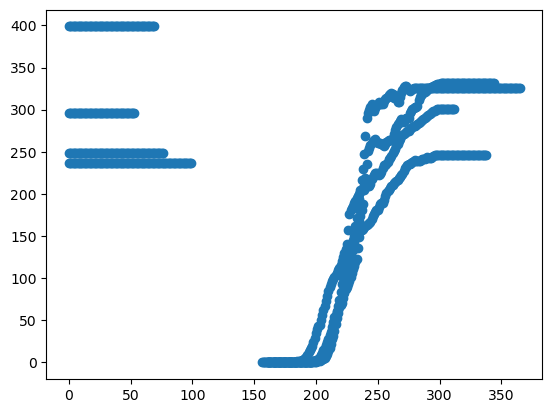

In [ ]:
import matplotlib.pyplot as plt
_ = tmp.loc[tmp.FactorialUID == 14689, ]
plt.scatter(x = _.DOY, y = _['Maize.AboveGround.Wt'])

# some of these run into the subsequent year. To deal with this...

In [ ]:
# find the smallest above ground weight within each year, usethat to get the first date within eacy year and then filter for the values that are >= the within year start.
_ = tmp.loc[:, ['FactorialUID', 'Year', 'Maize.AboveGround.Wt']].groupby(['FactorialUID', 'Year']).agg('min').reset_index()
_ = _.merge(tmp).loc[:, ['FactorialUID', 'Year', 'Date']].rename(columns={'Date': 'YearStart'})
tmp = tmp.merge(_, how='left')
tmp.head()

,Date,FactorialUID,Maize.AboveGround.Wt,Maize.LAI,yield_Kgha,Year,DOY,YearStart
0,7305,14689,398.689847,0.0,2220.623696,1990,0,7466
1,7305,14690,400.358238,0.0,2251.424315,1990,0,7466
2,7305,14691,395.890296,0.0,2220.743355,1990,0,7468
3,7305,14692,13.639644,0.0,0.000000,1990,0,7472
4,7305,14693,183.347526,0.0,671.582522,1990,0,7484


<matplotlib.collections.PathCollection>

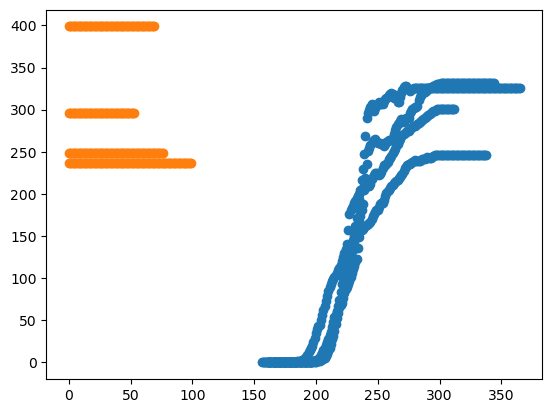

In [ ]:
# Retained values
_ = tmp.loc[((tmp.FactorialUID == 14689) & 
             (tmp.Date >= tmp.YearStart)
             ), ]
plt.scatter(x = _.DOY, y = _['Maize.AboveGround.Wt'])

_ = tmp.loc[((tmp.FactorialUID == 14689) & 
             (tmp.Date < tmp.YearStart)
             ), ]
plt.scatter(x = _.DOY, y = _['Maize.AboveGround.Wt'])

In [ ]:
# Turn results into tensor
tmp = x.results.merge(_prep_unix_epoch_to_date(max_year = 2025).loc[:, ['Unix', 'Year', 'DOY']].rename(columns={'Unix':'Date'}))

# find the smallest above ground weight within each year, usethat to get the first date within eacy year and then filter for the values that are >= the within year start.
_ = tmp.loc[:, ['FactorialUID', 'Year', 'Maize.AboveGround.Wt']].groupby(['FactorialUID', 'Year']).agg('min').reset_index()
_ = _.merge(tmp).loc[:, ['FactorialUID', 'Year', 'Date']].rename(columns={'Date': 'YearStart'})
tmp = tmp.merge(_, how='left')

tmp = tmp.loc[(tmp.Date >= tmp.YearStart), ]

tmp=tmp.drop(columns=['YearStart', 'Date'])

In [ ]:
tmp

,FactorialUID,Maize.AboveGround.Wt,Maize.LAI,yield_Kgha,Year,DOY
700,11811,0.022796,0.000627,0.0,1990,63
709,11811,0.025412,0.000627,0.0,1990,64
718,11811,0.025799,0.000627,0.0,1990,65
727,11811,0.029764,0.000770,0.0,1990,66
728,11813,0.022963,0.000631,0.0,1990,66
...,...,...,...,...,...,...
176095,11223,0.091054,0.002469,0.0,2020,77
176096,11224,0.079454,0.002124,0.0,2020,77
176097,11225,0.055656,0.001396,0.0,2020,77
176098,11226,0.042529,0.001012,0.0,2020,77


In [ ]:
# if making point estimates:
tmp.drop(columns='DOY').groupby(['FactorialUID', 'Year']).agg('max').reset_index()

,FactorialUID,Year,Maize.AboveGround.Wt,Maize.LAI,yield_Kgha
0,1148,1990,39.054240,0.118637,0.000000
1,1148,2000,1.001518,0.006011,0.000000
2,1148,2010,15.059317,0.047930,0.000000
3,1148,2020,14.655121,0.038642,0.000000
4,1149,1990,38.888598,0.118174,0.000000
...,...,...,...,...,...
987,14693,2020,203.324797,0.671335,1156.470502
988,14694,1990,342.189058,1.207914,1931.999337
989,14694,2000,384.122213,1.120015,1761.180531
990,14694,2010,698.100739,2.198472,2121.942218


In [ ]:
tmp

,FactorialUID,Maize.AboveGround.Wt,Maize.LAI,yield_Kgha,Year,DOY
700,11811,0.022796,0.000627,0.0,1990,63
709,11811,0.025412,0.000627,0.0,1990,64
718,11811,0.025799,0.000627,0.0,1990,65
727,11811,0.029764,0.000770,0.0,1990,66
728,11813,0.022963,0.000631,0.0,1990,66
...,...,...,...,...,...,...
176095,11223,0.091054,0.002469,0.0,2020,77
176096,11224,0.079454,0.002124,0.0,2020,77
176097,11225,0.055656,0.001396,0.0,2020,77
176098,11226,0.042529,0.001012,0.0,2020,77


<matplotlib.collections.PathCollection>

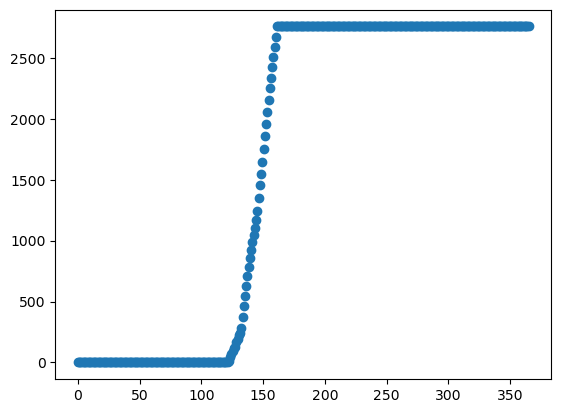

In [ ]:
mask = (
    (tmp.FactorialUID == 11811) & 
    (tmp.Year == 1990))

min, max = tmp.loc[mask, 'DOY'].agg(('min', 'max')).values

out = torch.zeros(365, 3)
out[min:(max+1), ] = torch.tensor(tmp.loc[mask, ['Maize.AboveGround.Wt', 'Maize.LAI', 'yield_Kgha']].to_numpy())

# propagate forward observations to all dates following the max
out[max:365, ] = out[max, ]

plt.scatter(x = np.linspace(0, 365, 365), y = out[:, 2].numpy())

## Define working set

In [ ]:
# Starting with a location and year

import plotly.express as px

fig = px.scatter_mapbox(Ids.loc[:, ['Longitude', 'Latitude']].drop_duplicates(), lon = 'Longitude', lat = 'Latitude',
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# -> File	Genotype  --Genotypes-> 
#	 FactorialUID     --Results->

lon, lat, soil = [-76.65611874999999, 42.733264, 141] #lon lat soil

# should allow ranges, slices, or all
sow = '19-Jun'
# allow all
cultivar = 'Cultivar1'


# -> File FactorialUID

mask = (
    (Ids.Longitude == lon) &
    (Ids.Latitude == lat) &
    (Ids.SoilIdx == soil) &
    (Ids.SowDate == sow) &
    (Ids.Genotype == cultivar))

Ids.loc[mask, ]

,File,Longitude,Latitude,SoilIdx,SowDate,Genotype,FactorialUID
0,sim_1697173207_62279,-76.656119,42.733264,141,19-Jun,Cultivar1,1
652550,sim_1698267607_61887,-76.656119,42.733264,141,19-Jun,Cultivar1,1
719200,sim_1698224407_24608,-76.656119,42.733264,141,19-Jun,Cultivar1,1551
825375,sim_1696770008_03244,-76.656119,42.733264,141,19-Jun,Cultivar1,13951
874201,sim_1697461207_67118,-76.656119,42.733264,141,19-Jun,Cultivar1,11627
966425,sim_1697475607_87027,-76.656119,42.733264,141,19-Jun,Cultivar1,5426
1170250,sim_1696842008_03237,-76.656119,42.733264,141,19-Jun,Cultivar1,8526
1430657,sim_1696417207_4919,-76.656119,42.733264,141,19-Jun,Cultivar1,13183
1786375,sim_1696265622_69985,-76.656119,42.733264,141,19-Jun,Cultivar1,10076
2339725,sim_1695672661_86607,-76.656119,42.733264,141,19-Jun,Cultivar1,275901


<__main__.temp>

In [ ]:
# Starting with a target set of genotypes
mask = Genotypes['Grain.MaximumGrainsPerCob.FixedValue'] == Genotypes['Grain.MaximumGrainsPerCob.FixedValue'].max()

Genotypes.loc[mask, ['File', 'Genotype']]

,File,Genotype
953,sim_1698224407_24608,Cultivar1
1001,sim_1697288407_92446,Cultivar24
1784,sim_1697115607_54721,Cultivar7
2156,sim_1697072407_46129,Cultivar4
2840,sim_1696626007_58404,Cultivar13


## Convert Small Datasets to Tensors
### `Genotypes` (Cultivar variables)

Warning! There are some NAs from Genotypes that are not "Cultivar\d+" Genotypes. These are calibrated genotypes that with defaults that are not clear.

In [ ]:
# keep as df or matrix (contains text)
Genotypes_lookup = Genotypes.loc[:, ['File', 'Genotype']].copy()

# ['Grain.MaximumGrainsPerCob.FixedValue',
#  'Grain.MaximumPotentialGrainSize.FixedValue',
#  'Phenology.FlagLeafToFlowering.Target.FixedValue',
#  'Phenology.FloweringToGrainFilling.Target.FixedValue',
#  'Phenology.GrainFilling.Target.FixedValue',
#  'Phenology.Juvenile.Target.FixedValue',
#  'Phenology.Maturing.Target.FixedValue',
#  'Phenology.MaturityToHarvestRipe.Target.FixedValue',
#  'Phenology.Photosensitive.Target.XYPairs.X__1',
#  'Phenology.Photosensitive.Target.XYPairs.X__2',
#  'Phenology.Photosensitive.Target.XYPairs.X__3',
#  'Phenology.Photosensitive.Target.XYPairs.Y__1',
#  'Phenology.Photosensitive.Target.XYPairs.Y__2',
#  'Phenology.Photosensitive.Target.XYPairs.Y__3',
#  'Rachis.DMDemands.Structural.DMDemandFunction.MaximumOrganWt.FixedValue']

Genotypes_cols = list(Genotypes)
Genotypes = Genotypes.drop(columns=['File', 'Genotype'])
# coerce None to NaN so we can convert to matrix
for e in list(Genotypes):
    Genotypes[e] = Genotypes[e].astype(float)

# Genotypes = torch.tensor(Genotypes.to_numpy())

In [ ]:
Genotypes_lookup

In [ ]:
# for a given idx and year...
idx_Ids = 1
year = 2000

In [ ]:
# get lookup information
lookup = Ids.loc[idx_Ids, ].to_dict()

In [ ]:
mask = ((Genotypes_lookup.File == lookup['File']) &  (Genotypes_lookup.Genotype == lookup['Genotype']))
# should only have a single value
assert sum(mask) == 1

idx_Geno = Genotypes_lookup.loc[mask, ].index[0]

Genotypes[idx_Geno]

In [ ]:
lookup

In [ ]:
lookup_date = _prep_unix_epoch_to_date(max_year = 2024)
lookup_date.head()

In [ ]:
Result = pq.read_table(apsimx_sim_parquet_dir+'/'+'sim_1698440407_4739.parquet').to_pandas()

In [ ]:
# lookup_* is a internally generated ref
# *_lookup is a table based on loaded apsimx data

In [ ]:
Result_lookup = Result.loc[:, ['Date', 'FactorialUID']].copy()
Result.drop(columns=['Date', 'FactorialUID'])

Result_list = list(Result)
Result = torch.tensor(Result.to_numpy())

Result_lookup.head()

In [ ]:
print(Result_lookup.shape)
Result_lookup.merge(lookup_date.rename(columns={'Unix':'Date'}), how = 'left')

In [ ]:
Result_lookup.loc[(Result_lookup.FactorialUID == 24024), ].merge(lookup_date.rename(columns={'Unix':'Date'}), how = 'left').Date.max()

In [ ]:
((19250-5285)/365)+1984

In [ ]:
lookup_date.loc[(lookup_date.Unix == 19250)]

In [ ]:
lookup

In [ ]:
# TODO make this valid for torch
sow_date = lookup_date.loc[((lookup_date.Year == year) & 
                            (lookup_date.SowDate == lookup['SowDate'])), 'Unix'].values[0]

# because of how this is set up index is also valid
_ = lookup_date.loc[(lookup_date.Year == year), 'Unix'].agg(['min', 'max'])
_['min']

In [ ]:
mask = (
    (Result_lookup['Date'] >= _['min']) & 
    (Result_lookup['Date'] <= _['max']) &
    (Result_lookup['FactorialUID'] == lookup['FactorialUID'])
    )

idx_Result = Result_lookup.loc[mask, ].index

Result[idx_Result, ].shape

In [ ]:
#TODO make sure there aren't any values before the SowDate
Result_list

In [ ]:
start = 129486



px.imshow((Result[(start-30):(start+30), 1:-1].numpy()[0:30, ]).transpose())

In [ ]:
import matplotlib.pyplot as plt

px.imshow(Result[idx_Result, ].numpy()[0:30, ])

In [ ]:
out = torch.zeros((365, 6))

Result_lookup.loc[mask, ['Date']].min().values[0] - _['min']

# sow_date - _['min']

In [ ]:
datetime.datetime(1970, 1, 1, 0, 0) + datetime.timedelta(10957)

In [ ]:


# idx_Result.to_list()
# Result

In [ ]:
Genotypes_cols